### Application on Detect hand-written digits project

### 1 - Get and understand the data

Let's use the digits data from sklearn

In [1]:
# Import some libraries
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Import some data
digits = load_digits()
# Show dimensionality
print(digits.data.shape)

(1797, 64)


<Figure size 432x288 with 0 Axes>

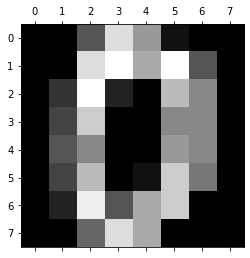

In [2]:
# Show one data
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

### 2 - Analyzing the data

In [3]:
# Importing other sklearn librairies
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, accuracy_score,adjusted_mutual_info_score,normalized_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics

In [4]:
label_encoder = LabelEncoder()

In [5]:
true_labels = label_encoder.fit_transform(digits.target)

Since the label_encoder has been fitted to the data, you can see the unique classes represented using .classes_. Store the length of the array to the variable n_clusters for later use:

In [6]:
label_encoder.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
n_clusters = len(label_encoder.classes_)

In [8]:
# preprocessing pipeline will implement the PCA class 
# to perform dimensionality reduction
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [9]:
# Build the k-means clustering pipeline
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=4,
               random_state=42,
           ),
       ),
   ]
)

In [10]:
# passing the "preprocessor" and "clusterer" pipelines to Pipeline
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)


In [11]:
# fitting the pipe to our data
pipe.fit(digits.data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=10, n_init=4,
                                         random_state=42))]))])

In [12]:
# The values below will help us to calculate the different scores
preprocessed_data = pipe["preprocessor"].transform(digits.data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [13]:
# Table of scores
pd.DataFrame.from_records([{
    'silhouette':silhouette_score(preprocessed_data, predicted_labels),
    'adjusted random score':adjusted_rand_score(true_labels, predicted_labels),
    'AMI score':adjusted_mutual_info_score(true_labels, predicted_labels),
    'NMI score':normalized_mutual_info_score(true_labels, predicted_labels),
    'Accuracy score':accuracy_score(true_labels, predicted_labels)
}])

,silhouette,adjusted random score,AMI score,NMI score,Accuracy score
0,0.391819,0.386833,0.518575,0.523364,0.216472


/home/caroline09/anaconda3/envs/machlearn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


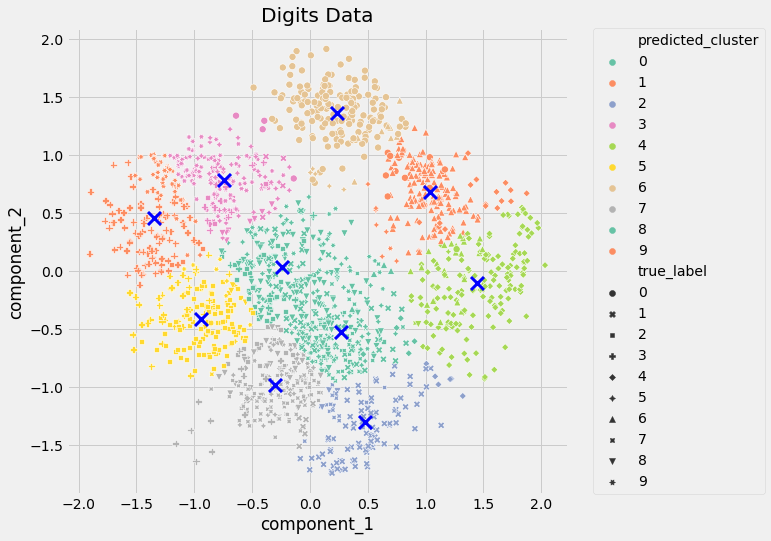

In [14]:
# Plotting the results
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(digits.data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)
centroids = pipe["clusterer"]["kmeans"].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="b", zorder=10)
scat.set_title(
    "Digits Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [15]:
pcadf.head()

,component_1,component_2,predicted_cluster,true_label
0,0.061137,1.378117,6,0
1,0.375737,-1.354664,2,1
2,0.370527,-0.675975,8,2
3,-0.997073,0.250191,9,3
4,1.484399,0.168711,4,4


As we can see above and below the number of a cluster doesn't necessarily correspond to the number of a true label.

In [16]:
pd.DataFrame(pcadf.groupby('predicted_cluster')['true_label'].value_counts()).head()

true_label
predicted_cluster true_label            
0                 8                   70
                  5                   43
                  2                   34
                  1                   28
                  9                   18

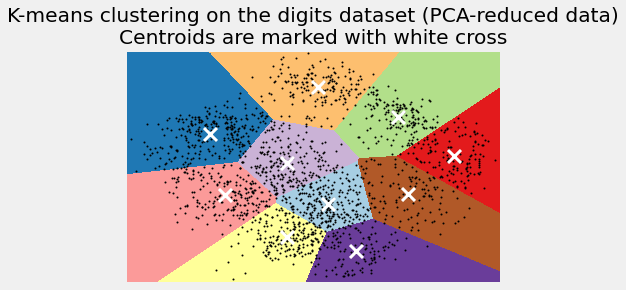

In [17]:
# Another method to plot the clusters
reduced_data = PCA(n_components=2).fit_transform(digits.data)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### 3 - Answering the questions

**What is the clustering ?**


We use clustering when we want to partition data into clusters. Data objects in one cluster tend to have more similarities to other objects in the same cluster than they are to other data objects into other clusters. Clustering is used in market segmentation where we try to find customers that are similar to each other whether in terms of behaviors or attributes.  

**Is a difficult problem ? Why ? Give the complexity in time and space**

Clustering is an unsupervised learning method since we don't have necessarily predefined values and we want to investigate the structure of data by grouping them into distinct subgroups.

Complexity of k-means:   
K is the number of clusters and T is the time to calculate the distance between two data objects. Time complexity of each iteration is O(KNT). I is the number of iteration in k-means algorithm.

**What are the metrics used for the clustering ?**

Some metrics are used for the clustering : 
- the Adjusted Mutual Information between two clusterings
- the Normalized Mutual Information betwwen two clusterings
- the Rand index adjusted for chance
- the Homogeneity metric of a cluster labeling given a groud truth
- The mean Silhouette Coefficient of all samples

**Write in only one sentence what you understood about 3 metrics with ground truth and 3 metrics without ground truth**

With ground truth :  
For Rand Index :  
Rand index requires knowledge of the ground truth classes which is almost never available in practice or requires manual assignment by human annotators (as in the supervised learning setting).  

For Homogeneity :  
All of its clusters contain only data points which are members of a single class.


Without ground truth :  
For AMI and NMI:  
It can be useful  to measure the agreement of two independant label assignments strategies on the same dataset when the real ground truth is unknown. 

For Silhoutte Coefficient :  
The Silhouette Coefficient is an example of an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters.

**Explain the difference between NMI and AMI** 

Normalized Mutual Information (NMI) is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation) whereas Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared.

### Application on Sentiment Wheel project

There is no preprocessing data except for the stop words and words starting with an @ symbol removal (for the second dataset). 

We will work with two datasets :
- one from Kaggle (Emotion_final.csv)
- one from data.world (text_emotion.csv)

In [18]:
# import some librairies
from time import time
from collections import defaultdict

import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import FastICA, KernelPCA, TruncatedSVD, SparsePCA, NMF, FactorAnalysis, LatentDirichletAllocation
import nltk

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### I . Analysis and classification on the first dataset

In [19]:
# Kaggle data
df1=pd.read_csv('Emotion_final.csv')

In [20]:
df1.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


As we can see above, we have 21459 non-null rows and 2 columns in the Kaggle dataset

<AxesSubplot:>

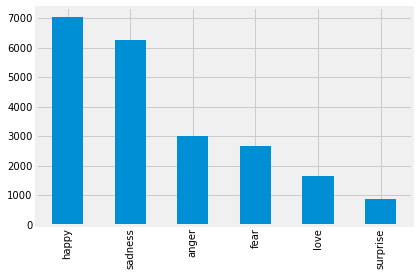

In [22]:
df1['Emotion'].value_counts().plot(kind='bar')

The "happy" and "sadness" emotions are the two main emotions that stand out.

### Preprocessing data

#### Stop words removal

We will suppress words that do not have any semantic or sentimental value/weight in a sentence such as pronouns or auxiliary verbs.

In [23]:
stopwords = set(nltk.corpus.stopwords.words("english"))

In [24]:
# Remind which the corpus and the targets are
corpus= np.array(df1['Text'])
targets = np.array(df1['Emotion'])

vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus)

#### Creating the benchmark 

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2,random_state=42)

In [26]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = kmeans.fit(data)
    fit_time = time() - t0
    results = [name, fit_time, kmeans.inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, kmeans.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, kmeans.labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [27]:
data=X_train
labels=y_train
n_clusters=6
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	2.535s	147554	0.006	0.006	0.006	0.008	0.005	0.032
random   	2.055s	149973	0.007	0.010	0.008	0.015	0.008	0.058
__________________________________________________________________________________


The scores are all very low for both models. That means the clusters we obtained don't reflect the grouping of texts by emotion.

### II . Analysis and classification on the second dataset (data.world)

In [28]:
# Loading the dataframe
df2=pd.read_csv('text_emotion.csv')

In [29]:
df2.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


There are 40000 rows and 4 columns on this dataset.

<AxesSubplot:>

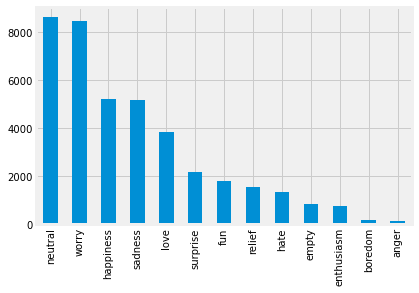

In [31]:
df2['sentiment'].value_counts().plot(kind='bar')

The sentiments 'neutral' and 'worry' have the highest frequency in the data.world dataset.

### Preprocessing data

In [32]:
# As recipient's name is not very useful in our dataset we decide to remove all the words starting with an @
def atremove(txt):
    quote=' '.join(word for word in txt.split(' ') if not word.startswith('@'))
    return quote

In [33]:
df2['content']=df2['content'].apply(lambda x: atremove(x))

In [34]:
# Vobabulary analysis
corpus2=df2['content']
targets2=df2['sentiment']

vec = CountVectorizer(stop_words=stopwords)
X2 = vec.fit_transform(corpus2)

#### Running the KMeans for the second dataset

In [35]:
corpus2= np.array(df2['content'])
targets2 = np.array(df2['sentiment'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, targets2, test_size=0.2,random_state=42)
data=X_train
labels=y_train
n_clusters=13
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	4.640s	146322	0.009	0.008	0.008	0.010	0.007	-0.011
random   	3.122s	147038	0.003	0.003	0.003	0.002	0.002	0.021
__________________________________________________________________________________


Like in the first dataset the scores are also very low. Apparently the two datasets are complex and creating reliable clusters seems to be also difficult.